In [34]:
import os
import sys

# For one-level deep notebook
BASE_DIR = os.path.abspath("../")
if BASE_DIR not in sys.path:
    sys.path = [BASE_DIR] + sys.path


from utils.data import load_images
from utils.other import (
    img_compare,
    make_noisy_images_gaussian,
    make_noisy_images_sp,
    make_noisy_images_speckle,
    batch_generate_noise,
    batch_img_compare,
)
from utils.plot import plot_intensity_dist, plot_zoom_image
import pickle
import pandas as pd
import numpy.typing as npt
from typing import Callable, List

In [18]:
%load_ext autoreload

%autoreload 1

%aimport utils.other

In [19]:
img_arr = load_images("../images/")

100it [00:01, 54.52it/s]

Image count: 100

MIN HEIGHT: 286
MAX HEIGHT: 600

MIN WIDTH: 282
MAX WIDTH: 640


## Generate noisy image sets

In [20]:
# create lambda noise functions which will be passed into the wrapper functions
gaus_lambda = lambda x:make_noisy_images_gaussian(x, 3)
sp_lambda = lambda x:make_noisy_images_sp(x, 3)
speckle_lambda = lambda x:make_noisy_images_speckle(x, 3)

In [21]:
# Read / create noisy images
def read_create_noise(
    path: str, img_arr: List[npt.NDArray], noisefunc: Callable
) -> List[npt.NDArray]:
    if os.path.exists(path):
        print("Loading", path)
        with open(path, "rb") as f:
            noise_arr = pickle.load(f)
    else:
        print("Creating noise and saving to", path)
        noise_arr = batch_generate_noise(img_arr, noisefunc)
        with open(path, "wb") as f:
            pickle.dump(noise_arr, f)
    return noise_arr

img_arr_gaus = read_create_noise("../results/img_arr_gaus.pickle", img_arr, gaus_lambda)
img_arr_sp = read_create_noise("../results/img_arr_sp.pickle", img_arr, sp_lambda)
img_arr_speckle = read_create_noise("../results/img_arr_speckle.pickle", img_arr, speckle_lambda)

Loading ../results/img_arr_gaus.pickle
Loading ../results/img_arr_sp.pickle
Loading ../results/img_arr_speckle.pickle


## Distribution plots of noise

In [22]:
img_idx = 2 # Image to be used for following plots

### Clean image

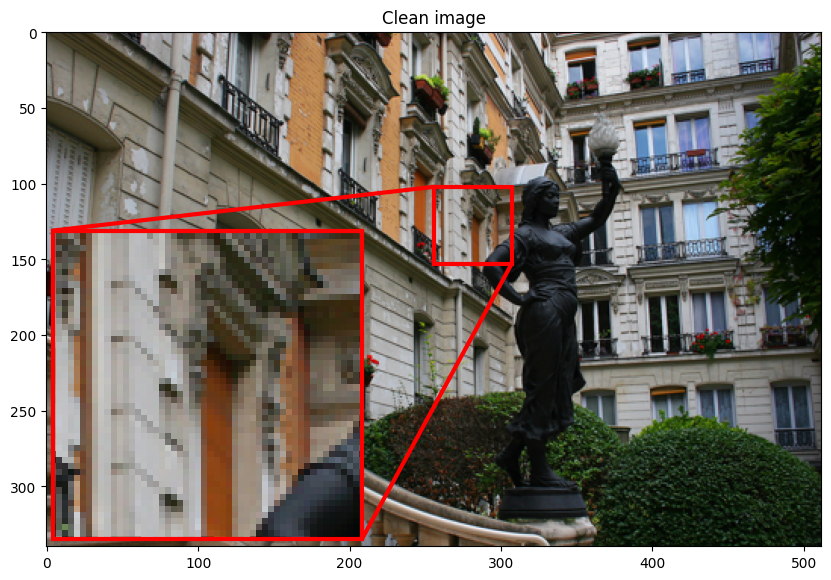

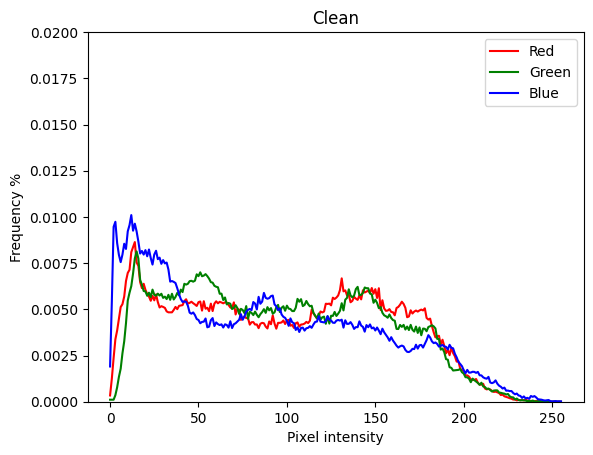

In [23]:
img = img_arr[img_idx]
plot_zoom_image(img, "Clean image")
plot_intensity_dist(img, "Clean")

In [24]:
print(img_compare(img, img))

{'mse': 0.0, 'ssim': 1.0, 'psnr': inf}


/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


### Gaussian noise
Gaussian-distributed additive noise with 0 mean and 0.01 variance.

The color intensity distribution plot is flatter compared to the clean image. The peaks at 0 and 255 is due to clipping of the color values beyond the allowed [0,255] range.

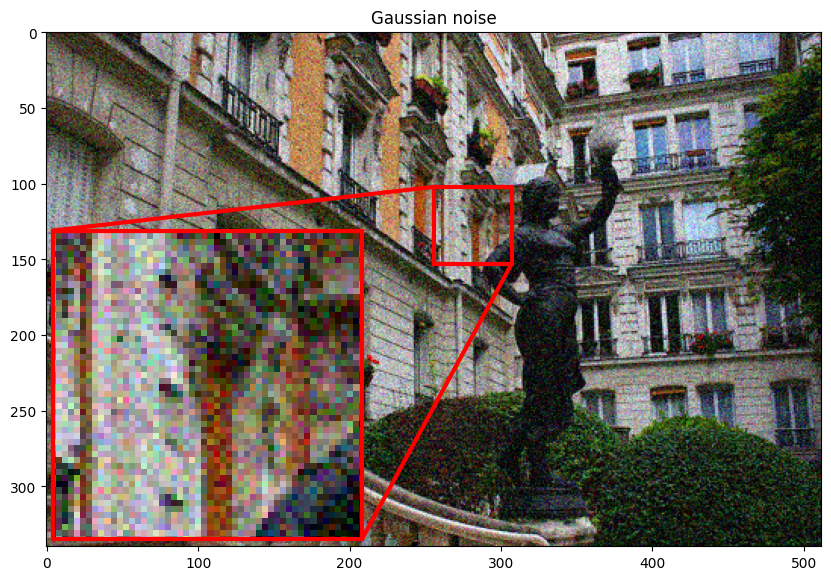

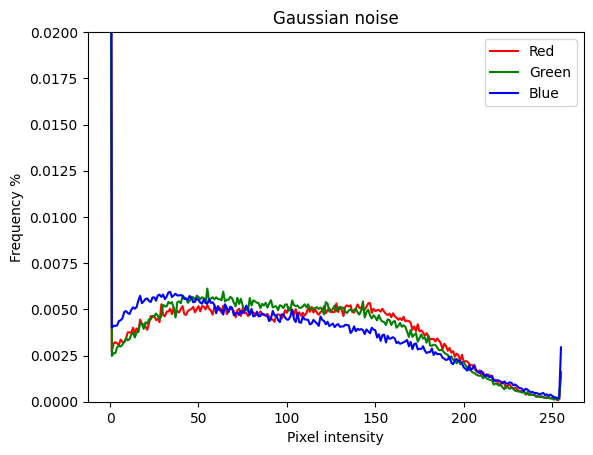

In [25]:
noisy_imgs = img_arr_gaus[img_idx]
plot_zoom_image(noisy_imgs[0], "Gaussian noise")
plot_intensity_dist(noisy_imgs[0], "Gaussian noise")

In [26]:
print(img_compare(img, noisy_imgs[0]))

{'mse': 595.8775869332108, 'ssim': 0.5628261536892154, 'psnr': 20.37923310489758}


### Salt & Pepper noise
Replaces random pixels with either the maximum or minimum possible pixel value.

Most of the color intensity distribution plot's shape was maintained, except for large peaks at 0 and 255. This is due salt & pepper noise being binary.

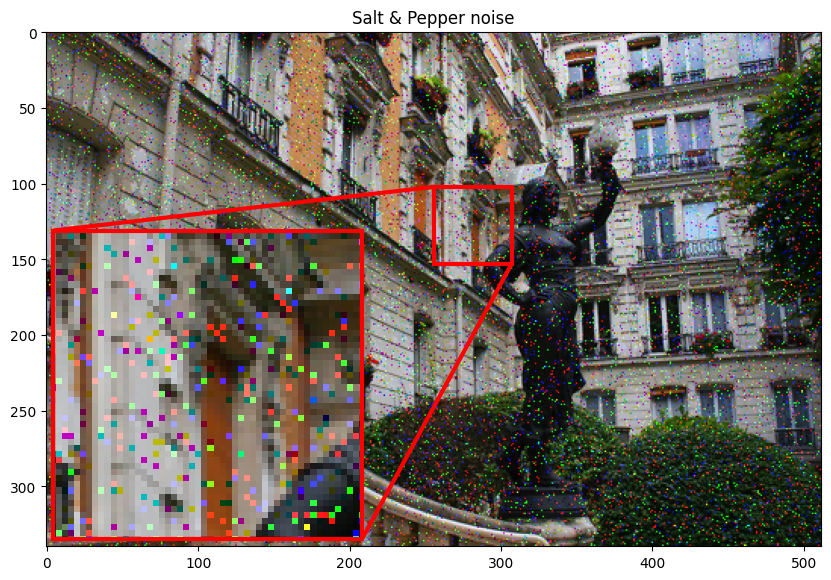

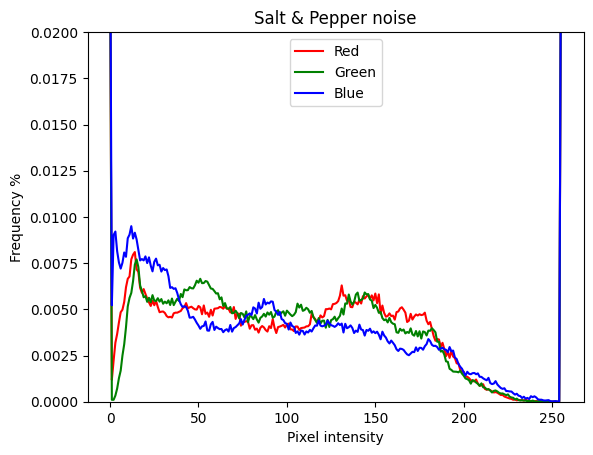

In [27]:
noisy_imgs = img_arr_sp[img_idx]
plot_zoom_image(noisy_imgs[0], "Salt & Pepper noise")
plot_intensity_dist(noisy_imgs[0], "Salt & Pepper noise")

In [28]:
print(img_compare(img, noisy_imgs[0]))

{'mse': 1048.7852117800246, 'ssim': 0.5660613926983443, 'psnr': 17.923938058392114}


### Speckle noise

Multiplicative noise using $out = image + n*image$, where $n$ is Gaussian noise with specified mean & variance.

Overall shape of the distribution is similar, although slightly muted.

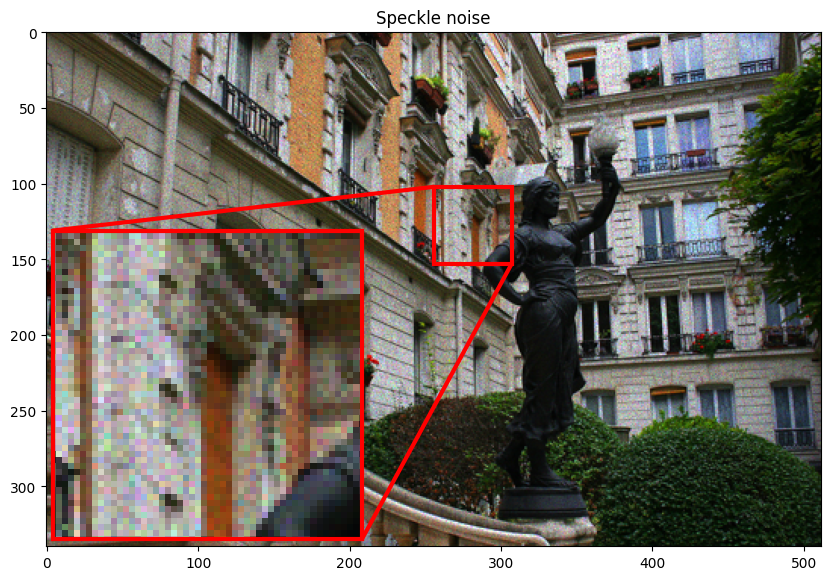

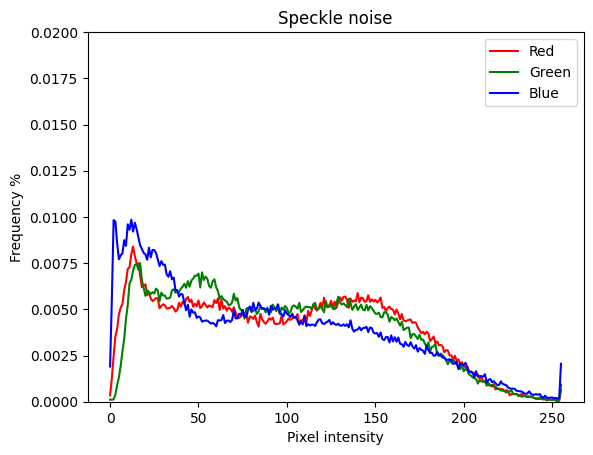

In [29]:
noisy_imgs = img_arr_speckle[img_idx]
plot_zoom_image(noisy_imgs[0], "Speckle noise")
plot_intensity_dist(noisy_imgs[0], "Speckle noise")

In [30]:
print(img_compare(img, noisy_imgs[0]))

{'mse': 121.77370366115196, 'ssim': 0.8621029802655694, 'psnr': 27.275268458702946}


## Baseline statistics for dataset
For each image and noise type combination calculate the MSE, SSIM and PSNR metrics.  
The average of 3 multiple readings for each image will be taken.  
The results will be logged and saved.
All noise was added using the defaults from the scikit-image library.

The matrics aren't comparable between noise type because the parameters used to generate the noise determines the results. This will be our baseline measurements against which further denoising improvements will be measured.

In [31]:
baseline = pd.concat(
    [
        batch_img_compare(
            img_arr=img_arr, noisy_arr=img_arr_gaus, noise_type_label="gaussian"
        ),
        batch_img_compare(
            img_arr=img_arr, noisy_arr=img_arr_sp, noise_type_label="s&p"
        ),
        batch_img_compare(
            img_arr=img_arr, noisy_arr=img_arr_speckle, noise_type_label="speckle"
        ),
    ]
)
baseline.to_parquet("../results/baseline_measurements.parquet")

100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


In [32]:
baseline.groupby("noise_type").mean()

,mse,ssim,psnr
noise_type,,,
gaussian,585.113426,0.502087,20.466775
s&p,1070.741189,0.518923,17.846945
speckle,162.381525,0.766721,26.271665
